In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import time
%matplotlib inline 


In [3]:
#Load data and format
mf_interaction = pd.read_hdf('18_10_29_mf_interaction_leftDeepCut_resnet50_mf_interaction_male218_10_29shuffle1_150000.h5')
#mf_interaction_female = pd.read_hdf('23_10_18_mf2_interaction1DeepCut_resnet50_mf_interaction_female18_10_23shuffle1_150000.h5')
mf_interaction = mf_interaction.T
#mf_interaction_female = mf_interaction_female.T

In [4]:
mf_interaction

0      \
scorer                                             bodyparts        coords                   
DeepCut_resnet50_mf_interaction_male218_10_29sh... female_nose      x           364.840541   
                                                                    y           374.084134   
                                                                    likelihood    0.437867   
                                                   female_left_ear  x           461.463412   
                                                                    y           404.549098   
                                                                    likelihood    0.664098   
                                                   female_tail      x           645.564222   
                                                                    y           500.205905   
                                                                    likelihood    0.926982   
                                                   female_right_ear x           462.918044   
                                                                    y           402.041034   
                                                                    likelihood    0.973309   
                                                   male_nose        x           652.244370   
                                                                    y           565.145241   
                                                                    likelihood    0.193565   
                                                   male_left_ear    x           742.096737   
                                                                    y           562.524060   
                                                                    likelihood    0.997232   
                                                   male_tail        x           925.908126   
                                                                    y           318.296602   
                                                                    likelihood    0.998841   
                                                   male_right_ear   x           692.112406   
                                                                    y           513.915180   
                                                                    likelihood    0.719965   

                                                                                     1      \
scorer                                             bodyparts        coords                   
DeepCut_resnet50_mf_interaction_male218_10_29sh... female_nose      x           385.246909   
                                                                    y           368.401606   
                                                                    likelihood    0.991851   
                                                   female_left_ear  x           486.771557   
                                                                    y           403.042024   
                                                                    likelihood    0.836207   
                                                   female_tail      x           648.547256   
                                                                    y           506.701206   
                                                                    likelihood    0.628814   
                                                   female_right_ear x           436.695022   
                                                                    y           446.062231   
                                                                    likelihood    0.919189   
                                                   male_nose        x           633.522418   
                                                                    y           553.873058   
                                                                    likelihood    0.081419   
                                          

In [5]:
#Copy and paste the name of the scorer from the dataframe above (also find out how to get the infor directly from the dataframe..)
scorer = 'DeepCut_resnet50_mf_interaction_male218_10_29shuffle1_150000'


In [6]:
# the df has a MultiIndex format, this means that you need to use .loc function on the frame with multiple indexes
# you cannot access the data with only the scorer as an index, or some other single index, it will not work
mf_interaction.loc[(scorer, 'male_nose')]

C:\Users\Tan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


,0,1,2,3,4,5,6,7,8,9,...,18300,18301,18302,18303,18304,18305,18306,18307,18308,18309
coords,,,,,,,,,,,,,,,,,,,,,
x,652.244370,633.522418,445.455082,628.811177,627.152844,616.566627,620.906453,612.545609,604.125705,596.052931,...,601.171621,605.566082,642.060092,629.310822,574.896635,630.548043,571.279742,625.674817,641.804430,660.737521
y,565.145241,553.873058,415.930466,547.208479,529.628964,516.768409,513.101360,480.594313,470.807727,464.805643,...,503.139897,508.590014,520.691612,519.836689,501.587489,505.426955,492.480366,527.770230,550.655874,577.103069
likelihood,0.193565,0.081419,0.217601,0.363200,0.973058,0.995662,0.166007,0.987449,0.925925,0.942696,...,0.861073,0.480855,0.827298,0.974945,0.396777,0.853437,0.171314,0.881207,0.962236,0.990916


### Clean up and interpolate coords

In [7]:
def get_x_y_data(data, scorer, bodypart):
    #get x_y_data
    print('bodypart is: ', bodypart)
    bodypart_data = (data.loc[(scorer, bodypart)])
    
    bodypart_data_x = bodypart_data.loc[('x')]
    bodypart_data_y = bodypart_data.loc[('y')]
    
    return bodypart_data_x, bodypart_data_y
    

In [8]:
def get_x_y_data_cleanup(data, scorer, bodypart, likelihood):
    # sets any value below a particular point to value 0 in x and y, this 0 value can then be used by a later
    #interpolation algorithm
    
    bodypart_data = (data.loc[(scorer, bodypart)])
    
    x_coords = []
    y_coords = []
    
    for index in bodypart_data:
        if bodypart_data.loc['likelihood'][index] > likelihood:
            x_coords.append(bodypart_data.loc['x'][index])
            y_coords.append(bodypart_data.loc['y'][index])
        else:
            x_coords.append(0)
            y_coords.append(0)
            
    return x_coords, y_coords

In [9]:
def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        if value > 0:
            start_value = value
            start_index = index
            break

    for x in range(start_index):
        coords[x] = start_value


In [10]:

def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                #print('interp_start_index: ', interp_start_index)
                #print('interp_start_value: ', value_before)
                #print('')

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                    #print('interp_end_index: ', interp_end_index)
                    #print('interp_end_value: ', value_after)
                    #print('')

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
                        print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                    #print('interp_diff_index is:', interp_diff_index)

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        #print('interp_index is:', interp_index)
                        #print('new_value should be:', new_values[x])
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
    print('function exiting')
    return(coords_list)


In [11]:
def plot_x_y_coords(x_coords, y_coords, start, end, n_data_plotted, data_index): 
    
    if end == 'end':
        end = len(x_coords)
    
    plt.subplot(3,n_data_plotted,data_index)
    plt.plot(x_coords[start:end])
    plt.subplot(3,n_data_plotted,data_index+n_data_plotted)
    plt.plot(y_coords[start:end])
    plt.subplot(3,n_data_plotted,data_index+ (2*n_data_plotted))
    plt.plot(x_coords[start:end], y_coords[start:end])

##### Look at raw data (see the imperfection due to failures of DLC to consistently predict correctly)

In [12]:
male_left_ear_x_raw, male_left_ear_y_raw = get_x_y_data(mf_interaction, scorer, 'male_left_ear')
male_right_ear_x_raw, male_right_ear_y_raw = get_x_y_data(mf_interaction, scorer, 'male_right_ear')
male_nose_x_raw, male_nose_y_raw = get_x_y_data(mf_interaction, scorer, 'male_nose')
male_tail_x_raw, male_tail_y_raw = get_x_y_data(mf_interaction, scorer, 'male_tail')

bodypart is:  male_left_ear
bodypart is:  male_right_ear
bodypart is:  male_nose
bodypart is:  male_tail


C:\Users\Tan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.


In [13]:
female_left_ear_x_raw, female_left_ear_y_raw = get_x_y_data(mf_interaction, scorer, 'female_left_ear')
female_right_ear_x_raw, female_right_ear_y_raw = get_x_y_data(mf_interaction, scorer, 'female_right_ear')
female_nose_x_raw, female_nose_y_raw = get_x_y_data(mf_interaction, scorer, 'female_nose')
female_tail_x_raw, female_tail_y_raw = get_x_y_data(mf_interaction, scorer, 'female_tail')

C:\Users\Tan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.


bodypart is:  female_left_ear
bodypart is:  female_right_ear
bodypart is:  female_nose
bodypart is:  female_tail


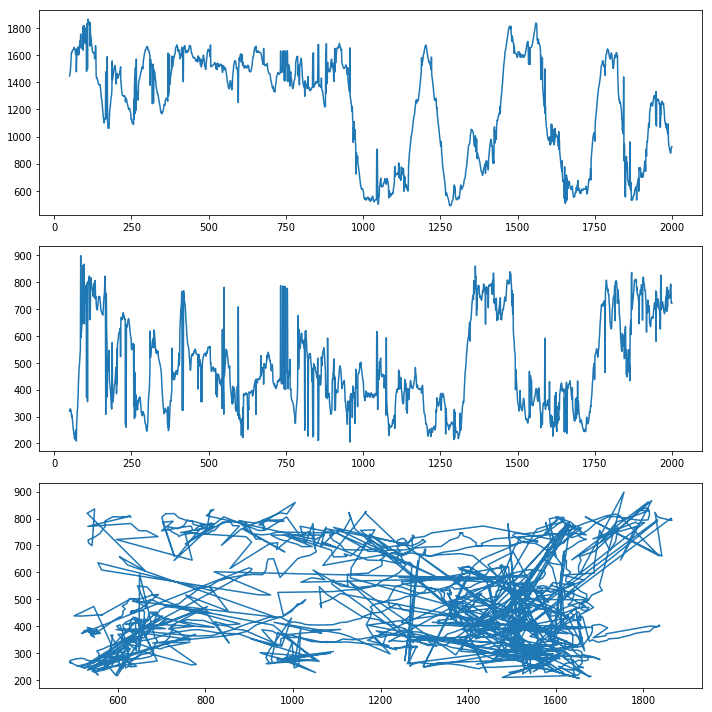

In [14]:
%matplotlib inline
plt.figure(figsize = (10,10))
#use plotting function to plot the coords and see them combined
plt.title('no interpolaton and no filter', size = 15)
plot_x_y_coords(male_nose_x_raw, male_nose_y_raw, 50, 2000, 1, 1)
plt.tight_layout()

#### Look at data after DLC predicted locations that are < a threshold_confidence are removed and interpolated over, starting by looking at only one bodypart

In [15]:
# this will set all values where DLC gave a predicted location at less than a specified confidence interval to 0
female_nose_0s_x, female_nose_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'female_nose', 0.98)

C:\Users\Tan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  """


In [16]:
female_nose_0s_y

[0,
 368.40160608291626,
 352.8179121017456,
 338.3994719982147,
 323.45913767814636,
 302.8442630767822,
 271.84634256362915,
 241.68246221542358,
 225.55373859405518,
 218.05178213119507,
 0,
 252.73387199640274,
 0,
 0,
 257.212366104126,
 269.0835003852844,
 271.5158882141113,
 272.79991149902344,
 271.59783601760864,
 267.4819287657738,
 274.12846517562866,
 283.6158118546009,
 283.8141097277403,
 277.3809050321579,
 274.8119488954544,
 0,
 263.3518695831299,
 0,
 0,
 0,
 186.5457468032837,
 0,
 0,
 0,
 166.300302028656,
 163.8168332129717,
 0,
 0,
 265.2934789657593,
 0,
 301.00189316272736,
 322.6380891799927,
 340.6860172152519,
 343.1231598854065,
 0,
 333.8345718383789,
 327.17314767837524,
 319.6019105911255,
 321.7108244895935,
 321.7251341342926,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 354.87657141685486,
 0,
 0,
 0,
 0,
 487.65663957595825,
 522.4417704343796,
 551.1651654243469,
 576.050041437149,
 0,
 651.0877179503441,
 693.5497734546661,
 712.

In [17]:
# this will interpolate linearly over all co-ordinates set to 0 in the previous function '0scleanup'
start_value_cleanup(female_nose_0s_x)
start_value_cleanup(female_nose_0s_y)
female_nose_interpolated_x = interp_0_coords(female_nose_0s_x)
female_nose_interpolated_y = interp_0_coords(female_nose_0s_y)

function exiting
function exiting


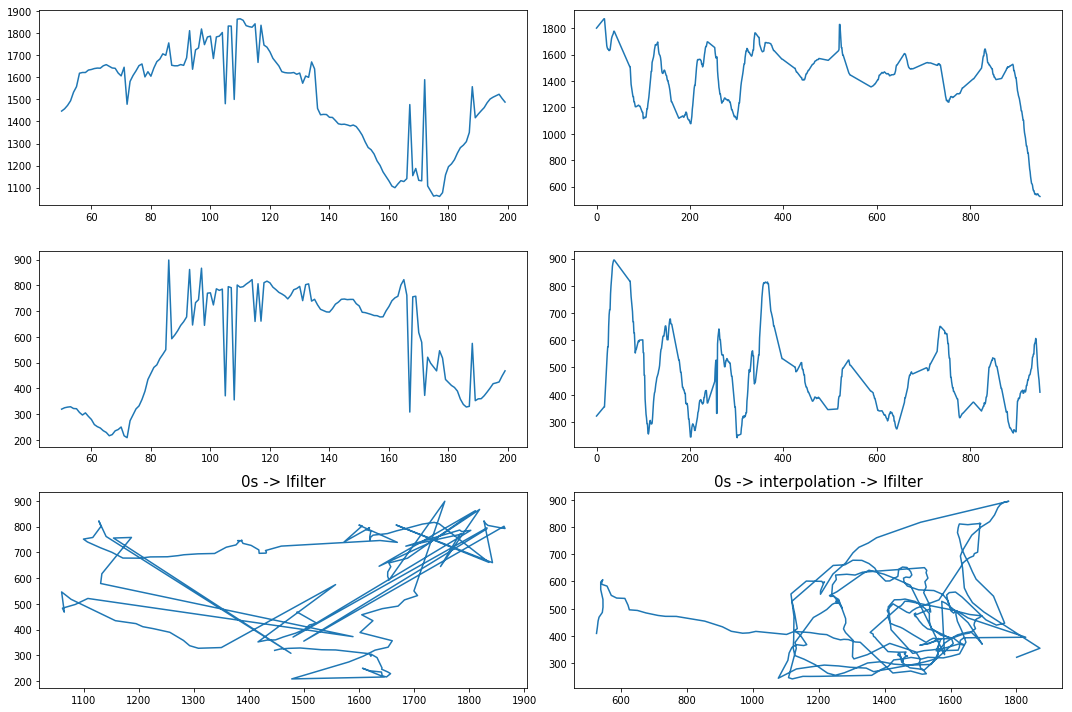

In [18]:
plt.figure(figsize = (15,10))

#plot raw
plt.title('no interpolaton and no filter', size = 15)
plot_x_y_coords(male_nose_x_raw, male_nose_y_raw, 50, 200, 2, 1)
plt.title('0s -> lfilter', size = 15)
plot_x_y_coords(female_nose_interpolated_x, female_nose_interpolated_y, 50, 1000, 2, 2)
plt.title('0s -> interpolation -> lfilter', size = 15)
plt.tight_layout()

#Q: Are there more suitable filters than linear filter?

#### Now can smooth over the data using linear fileter

In [19]:
from scipy.signal import lfilter

In [20]:
n= 20 # the larger n is, the smoother curve will be

nom = [1.0 / n] * n
denom = 1
female_nose_interpolated_lfilt_x = lfilter(nom,denom,female_nose_interpolated_x)
female_nose_interpolated_lfilt_y = lfilter(nom,denom,female_nose_interpolated_y)

#this is data before
female_nose_0s_lfilt_x = lfilter(nom,denom,female_nose_0s_x)
female_nose_0s_lfilt_y = lfilter(nom,denom,female_nose_0s_y)

C:\Users\Tan\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


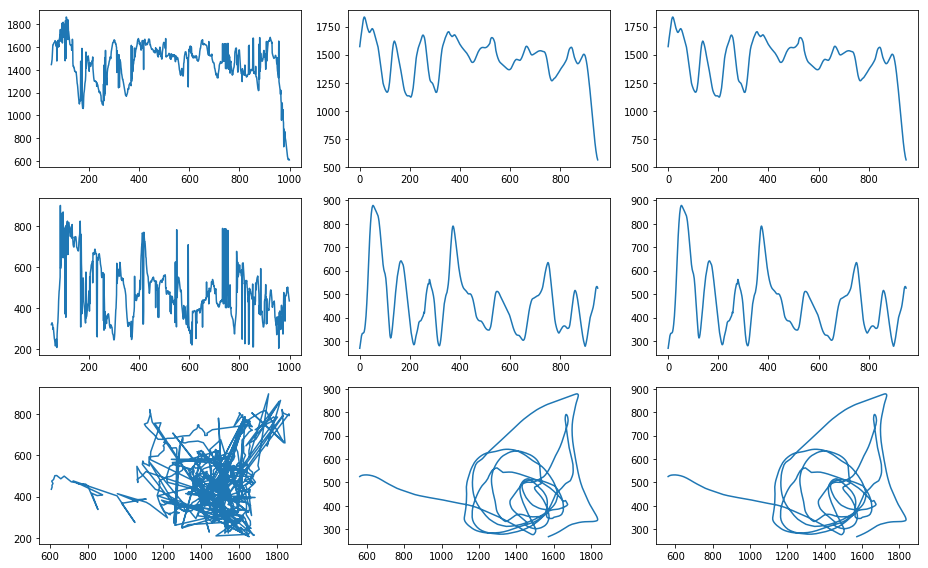

In [21]:
%matplotlib inline

#Comparing how good the home-made interpolation + lfilter is, compared to non-interpolated + filter

plt.figure(figsize = (13,8))

#plot unfiltered

#plt.title('no interpolaton and no filter', size = 15)
plot_x_y_coords(male_nose_x_raw, male_nose_y_raw, 50, 1000, 3, 1)
#plt.title('0s -> lfilter', size = 15)
plot_x_y_coords(female_nose_0s_lfilt_x, female_nose_0s_lfilt_y, 50, 1000, 3, 2)
#plt.title('0s -> interpolation -> lfilter', size = 15)
plot_x_y_coords(female_nose_interpolated_lfilt_x, female_nose_interpolated_lfilt_y, 50, 1000, 3, 3)



plt.tight_layout()

### Have determined that data looks best after likeihood cleanup, interpolation, and then a linear filter -> do for all the data

In [22]:
female_nose_0s_x, female_nose_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'female_nose', 0.98)
female_tail_0s_x, female_tail_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'female_tail', 0.98)
female_right_ear_0s_x, female_right_ear_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'female_right_ear', 0.98)
female_left_ear_0s_x, female_left_ear_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'female_left_ear', 0.98)


C:\Users\Tan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  """


In [23]:
male_nose_0s_x, male_nose_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'male_nose', 0.98)
male_tail_0s_x, male_tail_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'male_tail', 0.98)
male_right_ear_0s_x, male_right_ear_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'male_right_ear', 0.98)
male_left_ear_0s_x, male_left_ear_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'male_left_ear', 0.98)

C:\Users\Tan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  """


In [24]:
start_value_cleanup(male_nose_0s_x)
start_value_cleanup(male_nose_0s_y)
male_nose_interpolated_x = interp_0_coords(male_nose_0s_x)
male_nose_interpolated_y = interp_0_coords(male_nose_0s_y)

start_value_cleanup(male_tail_0s_x)
start_value_cleanup(male_tail_0s_y)
male_tail_interpolated_x = interp_0_coords(male_tail_0s_x)
male_tail_interpolated_y = interp_0_coords(male_tail_0s_y)

start_value_cleanup(male_right_ear_0s_x)
start_value_cleanup(male_right_ear_0s_y)
male_right_ear_interpolated_x = interp_0_coords(male_right_ear_0s_x)
male_right_ear_interpolated_y = interp_0_coords(male_right_ear_0s_y)

start_value_cleanup(male_left_ear_0s_x)
start_value_cleanup(male_left_ear_0s_y)
male_left_ear_interpolated_x = interp_0_coords(male_left_ear_0s_x)
male_left_ear_interpolated_y = interp_0_coords(male_left_ear_0s_y)

function exiting
function exiting
function exiting
function exiting
function exiting
function exiting
function exiting
function exiting


In [25]:
start_value_cleanup(female_nose_0s_x)
start_value_cleanup(female_nose_0s_y)
female_nose_interpolated_x = interp_0_coords(female_nose_0s_x)
female_nose_interpolated_y = interp_0_coords(female_nose_0s_y)

start_value_cleanup(female_tail_0s_x)
start_value_cleanup(female_tail_0s_y)
female_tail_interpolated_x = interp_0_coords(female_tail_0s_x)
female_tail_interpolated_y = interp_0_coords(female_tail_0s_y)

start_value_cleanup(female_right_ear_0s_x)
start_value_cleanup(female_right_ear_0s_y)
female_right_ear_interpolated_x = interp_0_coords(female_right_ear_0s_x)
female_right_ear_interpolated_y = interp_0_coords(female_right_ear_0s_y)

start_value_cleanup(female_left_ear_0s_x)
start_value_cleanup(female_left_ear_0s_y)
female_left_ear_interpolated_x = interp_0_coords(female_left_ear_0s_x)
female_left_ear_interpolated_y = interp_0_coords(female_left_ear_0s_y)

function exiting
function exiting
function exiting
function exiting
function exiting
function exiting
function exiting
function exiting


In [26]:
female_nose_interpolated_lfilt_x = lfilter(nom,denom,female_nose_interpolated_x)
female_nose_interpolated_lfilt_y = lfilter(nom,denom,female_nose_interpolated_y)

female_tail_interpolated_lfilt_x = lfilter(nom,denom,female_tail_interpolated_x)
female_tail_interpolated_lfilt_y = lfilter(nom,denom,female_tail_interpolated_y)

female_right_ear_interpolated_lfilt_x = lfilter(nom,denom,female_right_ear_interpolated_x)
female_right_ear_interpolated_lfilt_y = lfilter(nom,denom,female_right_ear_interpolated_y)

female_left_ear_interpolated_lfilt_x = lfilter(nom,denom,female_left_ear_interpolated_x)
female_left_ear_interpolated_lfilt_y = lfilter(nom,denom,female_left_ear_interpolated_y)

C:\Users\Tan\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


In [27]:
male_nose_interpolated_lfilt_x = lfilter(nom,denom,male_nose_interpolated_x)
male_nose_interpolated_lfilt_y = lfilter(nom,denom,male_nose_interpolated_y)

male_tail_interpolated_lfilt_x = lfilter(nom,denom,male_tail_interpolated_x)
male_tail_interpolated_lfilt_y = lfilter(nom,denom,male_tail_interpolated_y)

male_right_ear_interpolated_lfilt_x = lfilter(nom,denom,male_right_ear_interpolated_x)
male_right_ear_interpolated_lfilt_y = lfilter(nom,denom,male_right_ear_interpolated_y)

male_left_ear_interpolated_lfilt_x = lfilter(nom,denom,male_left_ear_interpolated_x)
male_left_ear_interpolated_lfilt_y = lfilter(nom,denom,male_left_ear_interpolated_y)

C:\Users\Tan\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


### Animation

In [ ]:
%matplotlib

fig, ax = plt.subplots(figsize=(8,7))

pause = 1/35 # should match fps of camera

for t in range(len(male_nose_interpolated_lfilt_x)):
    if t == 0:
        points1, = ax.plot(male_nose_interpolated_lfilt_x, male_nose_interpolated_lfilt_y, marker='o', linestyle='None', color = 'blue')
        points2, = ax.plot(male_tail_interpolated_lfilt_x, male_tail_interpolated_lfilt_y, marker='o', linestyle='None', color = 'black')
        points3, = ax.plot(male_right_ear_interpolated_lfilt_x, male_right_ear_interpolated_lfilt_y, marker='o', linestyle='None', color = 'cyan')
        points4, = ax.plot(male_left_ear_interpolated_lfilt_x, male_left_ear_interpolated_lfilt_y, marker='o', linestyle='None', color = 'lightblue')
        
        points5, = ax.plot(female_nose_interpolated_lfilt_x, female_nose_interpolated_lfilt_y, marker='o', linestyle='None', color = 'red')
        points6, = ax.plot(female_tail_interpolated_lfilt_x, female_tail_interpolated_lfilt_y, marker='o', linestyle='None', color = 'pink')
        points7, = ax.plot(female_right_ear_interpolated_lfilt_x, female_right_ear_interpolated_lfilt_y, marker='o', linestyle='None', color = 'purple')
        points8, = ax.plot(female_left_ear_interpolated_lfilt_x, female_left_ear_interpolated_lfilt_y, marker='o', linestyle='None', color = 'salmon')        
        
        ax.set_xlim(500, 2000) 
        ax.set_ylim(0, 1000) 
    else:
        x = male_nose_interpolated_lfilt_x[t]
        y =male_nose_interpolated_lfilt_y[t]
        points1.set_data(x, y)
        
        x = male_tail_interpolated_lfilt_x[t]
        y = male_tail_interpolated_lfilt_y[t]
        points2.set_data(x, y)
        
        x = male_right_ear_interpolated_lfilt_x[t]
        y = male_right_ear_interpolated_lfilt_y[t]
        points3.set_data(x, y)
        
        x = male_left_ear_interpolated_lfilt_x[t]
        y = male_left_ear_interpolated_lfilt_y[t]
        points4.set_data(x, y)
        
        
        
        x = female_nose_interpolated_lfilt_x[t]
        y = female_nose_interpolated_lfilt_y[t]
        points5.set_data(x, y)
        
        x = female_tail_interpolated_lfilt_x[t]
        y = female_tail_interpolated_lfilt_y[t]
        points6.set_data(x, y)
        
        x = female_right_ear_interpolated_lfilt_x[t]
        y = female_right_ear_interpolated_lfilt_y[t]
        points7.set_data(x, y)
        
        x = female_left_ear_interpolated_lfilt_x[t]
        y = female_left_ear_interpolated_lfilt_y[t]
        points8.set_data(x, y)
        
    plt.pause(pause)

In [ ]:
male_nose_interpolated_lfilt_x

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation


def animate2(i):

    ax1.clear()
    ax1.plot(male_nose_interpolated_lfilt_x[i], male_nose_interpolated_lfilt_x[i])

# ---

#test_data=np.array([[3, 7],[1, 2],[8, 11],[5, -12],[20, 25], [-3, 30], [2,2], [17, 17]])

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

# create animation
animation.FuncAnimation(fig, animate2, frames=range(1, len(male_nose_interpolated_lfilt_x)), interval=1/30, repeat=False)

# start animation
HTML(anim.to_html5_video())

In [ ]:
fig, ax = plt.subplots()

ax.set_xlim(500, 2000) 
ax.set_ylim(0, 1000) 

line, = ax.plot([], [], lw=20)

#ax.set_xlim(( 0, 2))
#ax.set_ylim((-2, 2))

#line, = ax.plot([], [], lw=20)


def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = np.array(male_nose_interpolated_lfilt_x)[i]
    y = np.array(male_nose_interpolated_lfilt_y)[i]
    line.set_data(x, y)
# animation function. This is called sequentially
#    x = np.linspace(0, 2, 1000)
#    y = np.sin(2 * np.pi * (x - 0.01 * i))
#    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=500, interval=20, blit=True)

HTML(anim.to_html5_video())


In [ ]:
data_x = np.array(mother_earR_x)

In [ ]:
data = np.array([mother_earR_x, mother_earR_y])

In [ ]:
data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create initial data
data = np.array([mother_earR_x, mother_earR_y])

# Create figure and axes
fig = plt.figure()
ax = plt.axes(xlim=(0, 200), ylim=(0, 10))

# Create initial objects
line, = ax.plot([], [], 'r-')
annotation = ax.annotate('A0', xy=(data[0][0], data[1][0]))
annotation.set_animated(True)

# Create the init function that returns the objects
# that will change during the animation process
def init():
    return line, annotation

# Create the update function that returns all the
# objects that have changed
def update(num):
    newData = np.array([[1 + num, 2 + num / 2, 3, 4 - num / 4, 5 + num],
                        [7, 4, 9 + num / 3, 2, 3]])
    line.set_data(newData)
    # This is not working i 1.2.1
    # annotation.set_position((newData[0][0], newData[1][0]))
    annotation.xytext = (newData[0][0], newData[1][0])
    return line, annotation

anim = animation.FuncAnimation(fig, update, frames=25, init_func=init,
                               interval=200, blit=True)
HTML(anim.to_html5_video())

### OUR SHITTY CODE

In [48]:
def zip_xy(x_pos, y_pos):
    
    xy = np.stack((x_pos, y_pos), axis =-1)
    
    return xy

female_nose_xy = zip_xy(female_nose_interpolated_lfilt_x,female_nose_interpolated_lfilt_y)
female_tail_xy = zip_xy(female_tail_interpolated_lfilt_x,female_tail_interpolated_lfilt_y)
female_right_ear_xy = zip_xy(female_right_ear_interpolated_lfilt_x,female_right_ear_interpolated_lfilt_y)
female_left_ear_xy = zip_xy(female_left_ear_interpolated_lfilt_x,female_left_ear_interpolated_lfilt_y)

female_body_midpt_xy = (female_nose_xy + female_tail_xy)/2

male_nose_xy = zip_xy(male_nose_interpolated_lfilt_x,male_nose_interpolated_lfilt_y)
male_tail_xy = zip_xy(male_tail_interpolated_lfilt_x,male_tail_interpolated_lfilt_y)
male_right_ear_xy = zip_xy(male_right_ear_interpolated_lfilt_x,male_right_ear_interpolated_lfilt_y)
male_left_ear_xy = zip_xy(male_left_ear_interpolated_lfilt_x,male_left_ear_interpolated_lfilt_y)

male_body_midpt_xy = (male_nose_xy + male_tail_xy)/2

In [ ]:
### for nose-nose/tail/body distances

In [49]:
def find_distance(body_part_1_xy, body_part_2_xy):
    
    vector_btwn_parts = body_part_1_xy - body_part_2_xy
    distanceOverTime = np.linalg.norm(vector_btwn_parts,axis=1)
    #distanceOverTime = np.sqrt(((body_part_1_xy[:,0]-body_part_2_xy[:,0])**2) + ((body_part_1_xy[:,1]-body_part_2_xy[:,1])**2))
    return distanceOverTime

nose_nose_dist = find_distance(male_nose_xy, female_nose_xy)
male_nose_female_tail_dist  = find_distance(male_nose_xy, female_tail_xy)
male_nose_female_body_dist  = find_distance(male_nose_xy, female_body_midpt_xy)

female_nose_male_tail_dist  = find_distance(female_nose_xy, male_tail_xy)
female_nose_male_body_dist  = find_distance(female_nose_xy, male_body_midpt_xy)

In [84]:
def sniffing_threshold(distanceOverTime, threshold=50):
    sniffing_behaviour = []
    
    for distance in distanceOverTime:
        if distance < threshold:
            sniffing_behaviour.append(1)
        else:
            sniffing_behaviour.append(0)
    
    return sniffing_behaviour

In [89]:
mutual_sniffing = sniffing_threshold(nose_nose_dist)

male_anogenital_sniffing = sniffing_threshold(male_nose_female_tail_dist)
male_body_sniffing = sniffing_threshold(male_nose_female_body_dist)

female_anogenital_sniffing = sniffing_threshold(female_nose_male_tail_dist)
female_body_sniffing = sniffing_threshold(female_nose_male_body_dist)

In [96]:
%matplotlib

fig, axes = plt.subplots(nrows=3, sharex = True, figsize=(15,9))

axes[0].plot(mutual_sniffing)
axes[0].set_title("mutual sniffing (nose-nose)")

axes[1].plot(male_anogenital_sniffing, color = 'red')
axes[1].plot(male_body_sniffing, color = 'blue')
axes[1].set_title("male anogenital(red)/ body(blue) sniffing")

axes[2].plot(female_anogenital_sniffing, color = 'red')
axes[2].plot(female_body_sniffing, color = 'blue')
axes[2].set_title("female anogenital(red)/ body(blue) sniffing")

Using matplotlib backend: Qt5Agg


Text(0.5,1,'female anogenital(red)/ body(blue) sniffing')

In [ ]:
### orienting, male/female "interest"

In [65]:
def target_theta(nose_xy, left_ear_xy, right_ear_xy, target_xy):
    
    mid_pt_btwn_ears_xy = (left_ear_xy+right_ear_xy)/2
    
    head_dir_vector = nose_xy - mid_pt_btwn_ears_xy
      
    ear_mid_pt_to_target_vector =  target_xy - mid_pt_btwn_ears_xy
    
    theta_to_target = []
    
    for t in range(len(head_dir_vector)):
        theta = np.arccos(np.dot(head_dir_vector[t],ear_mid_pt_to_target_vector[t])/np.linalg.norm(head_dir_vector[t])/np.linalg.norm(ear_mid_pt_to_target_vector[t]))
        theta_to_target.append(theta)
        
    return theta_to_target

In [70]:
def orienting_threshold(theta_to_target,threshold = np.pi/4):
    orienting_to_target = []
    
    for theta in theta_to_target:
        if theta < threshold or theta > 2*np.pi - threshold:
            orienting_to_target.append(1)
        else:
            orienting_to_target.append(0)   
            
    return orienting_to_target

In [98]:
def interest(nose_xy, left_ear_xy, right_ear_xy, target_nose_xy, target_tail_xy):
    
    theta_to_target_nose = target_theta(nose_xy, left_ear_xy, right_ear_xy, target_nose_xy)
    theta_to_target_tail = target_theta(nose_xy, left_ear_xy, right_ear_xy, target_tail_xy)
    
    orienting_to_nose = orienting_threshold(theta_to_target_nose)
    orienting_to_tail = orienting_threshold(theta_to_target_tail)
    
    interest = orienting_to_nose + orienting_to_tail
    
    return interest, orienting_to_nose, orienting_to_tail

In [105]:
female_interest = interest(female_nose_xy, female_left_ear_xy, female_right_ear_xy, male_nose_xy, male_tail_xy)
male_interest = interest(male_nose_xy, male_left_ear_xy, male_right_ear_xy, female_nose_xy, female_tail_xy)

In [107]:
%matplotlib

fig, axes = plt.subplots(nrows=2, sharex = True, figsize=(15,9))

axes[0].plot(male_interest)
axes[0].set_title("male interest")

axes[1].plot(female_interest)
axes[1].set_title("female interest")

Using matplotlib backend: Qt5Agg


ValueError: setting an array element with a sequence.